In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    early_stopping_patience = 5
    dataset_name = "cifar100"
    num_classes = 100
    input_shape = (32, 32, 3)
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_epochs = 100
    image_size = 72  # We'll resize input images to this size
    patch_size = 6  # Size of the patches to be extract from the input images
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]  # Size of the transformer layers
    transformer_layers = 8
    mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import tensorflow_addons as tfa

/home/ml/anaconda3/envs/ml_tf_torch/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


# Prepare the data

In [4]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# Use data augmentation

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(CFG.image_size, CFG.image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement multilayer perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [7]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


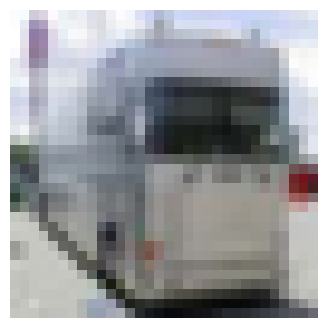

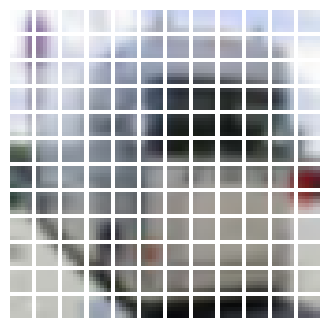

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(CFG.image_size, CFG.image_size)
)
patches = Patches(CFG.patch_size)(resized_image)
print(f"Image size: {CFG.image_size} X {CFG.image_size}")
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (CFG.patch_size, CFG.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Implement the patch encoding layer

In [9]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT model

In [10]:
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=CFG.input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(CFG.patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(CFG.num_patches, CFG.projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(CFG.transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=CFG.num_heads, key_dim=CFG.projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=CFG.transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=CFG.mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(CFG.num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train, and evaluate the mode

In [11]:
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                      factor=0.7,
                                                      min_delta=0.001,
                                                      patience=3,
                                                      verbose=1,
                                                      mode="auto")

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=CFG.early_stopping_patience,
    restore_best_weights=True,
    min_delta=0.001,
)

In [12]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = CFG.BASE+"/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=CFG.batch_size,
        epochs=CFG.num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, reduceLROnPlat, early_stopping],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [13]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 17s 70ms/step - loss: 4.4627 - accuracy: 0.0464 - top-5-accuracy: 0.1650 - val_loss: 3.8750 - val_accuracy: 0.1162 - val_top-5-accuracy: 0.3288 - lr: 0.0010
Epoch 2/100
176/176 [==============================] - 12s 67ms/step - loss: 3.9088 - accuracy: 0.0981 - top-5-accuracy: 0.3022 - val_loss: 3.5989 - val_accuracy: 0.1490 - val_top-5-accuracy: 0.4084 - lr: 0.0010
Epoch 3/100
176/176 [==============================] - 12s 67ms/step - loss: 3.6611 - accuracy: 0.1377 - top-5-accuracy: 0.3744 - val_loss: 3.3325 - val_accuracy: 0.2074 - val_top-5-accuracy: 0.4730 - lr: 0.0010
Epoch 4/100
176/176 [==============================] - 12s 67ms/step - loss: 3.4838 - accuracy: 0.1663 - top-5-accuracy: 0.4283 - val_loss: 3.2102 - val_accuracy: 0.2272 - val_top-5-accuracy: 0.5040 - lr: 0.0010
Epoch 5/100
176/176 [==============================] - 12s 67ms/step - loss: 3.3138 - accuracy: 0.1940 - top-5-accuracy: 0.4737 - val_loss: 3.0138 - val

Epoch 39/100
176/176 [==============================] - 13s 73ms/step - loss: 1.1955 - accuracy: 0.6555 - top-5-accuracy: 0.9098 - val_loss: 1.8754 - val_accuracy: 0.5240 - val_top-5-accuracy: 0.8034 - lr: 7.0000e-04
Epoch 40/100
176/176 [==============================] - 11s 64ms/step - loss: 1.1911 - accuracy: 0.6548 - top-5-accuracy: 0.9086 - val_loss: 1.8678 - val_accuracy: 0.5230 - val_top-5-accuracy: 0.7980 - lr: 7.0000e-04
Epoch 41/100
176/176 [==============================] - 13s 73ms/step - loss: 1.1644 - accuracy: 0.6616 - top-5-accuracy: 0.9139 - val_loss: 1.8701 - val_accuracy: 0.5266 - val_top-5-accuracy: 0.7990 - lr: 7.0000e-04
Epoch 42/100
176/176 [==============================] - 13s 73ms/step - loss: 1.1376 - accuracy: 0.6662 - top-5-accuracy: 0.9169 - val_loss: 1.8552 - val_accuracy: 0.5280 - val_top-5-accuracy: 0.8068 - lr: 7.0000e-04
Epoch 43/100
176/176 [==============================] - 13s 73ms/step - loss: 1.1175 - accuracy: 0.6718 - top-5-accuracy: 0.9221 - v

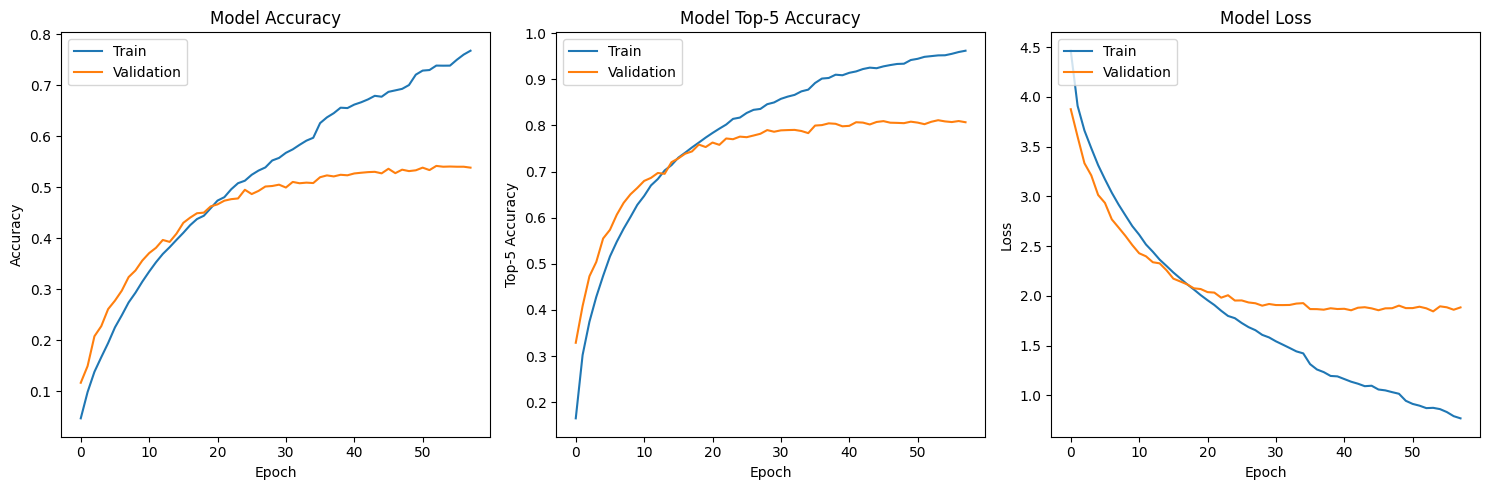

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

1/1 [==============================] - 0s 15ms/step


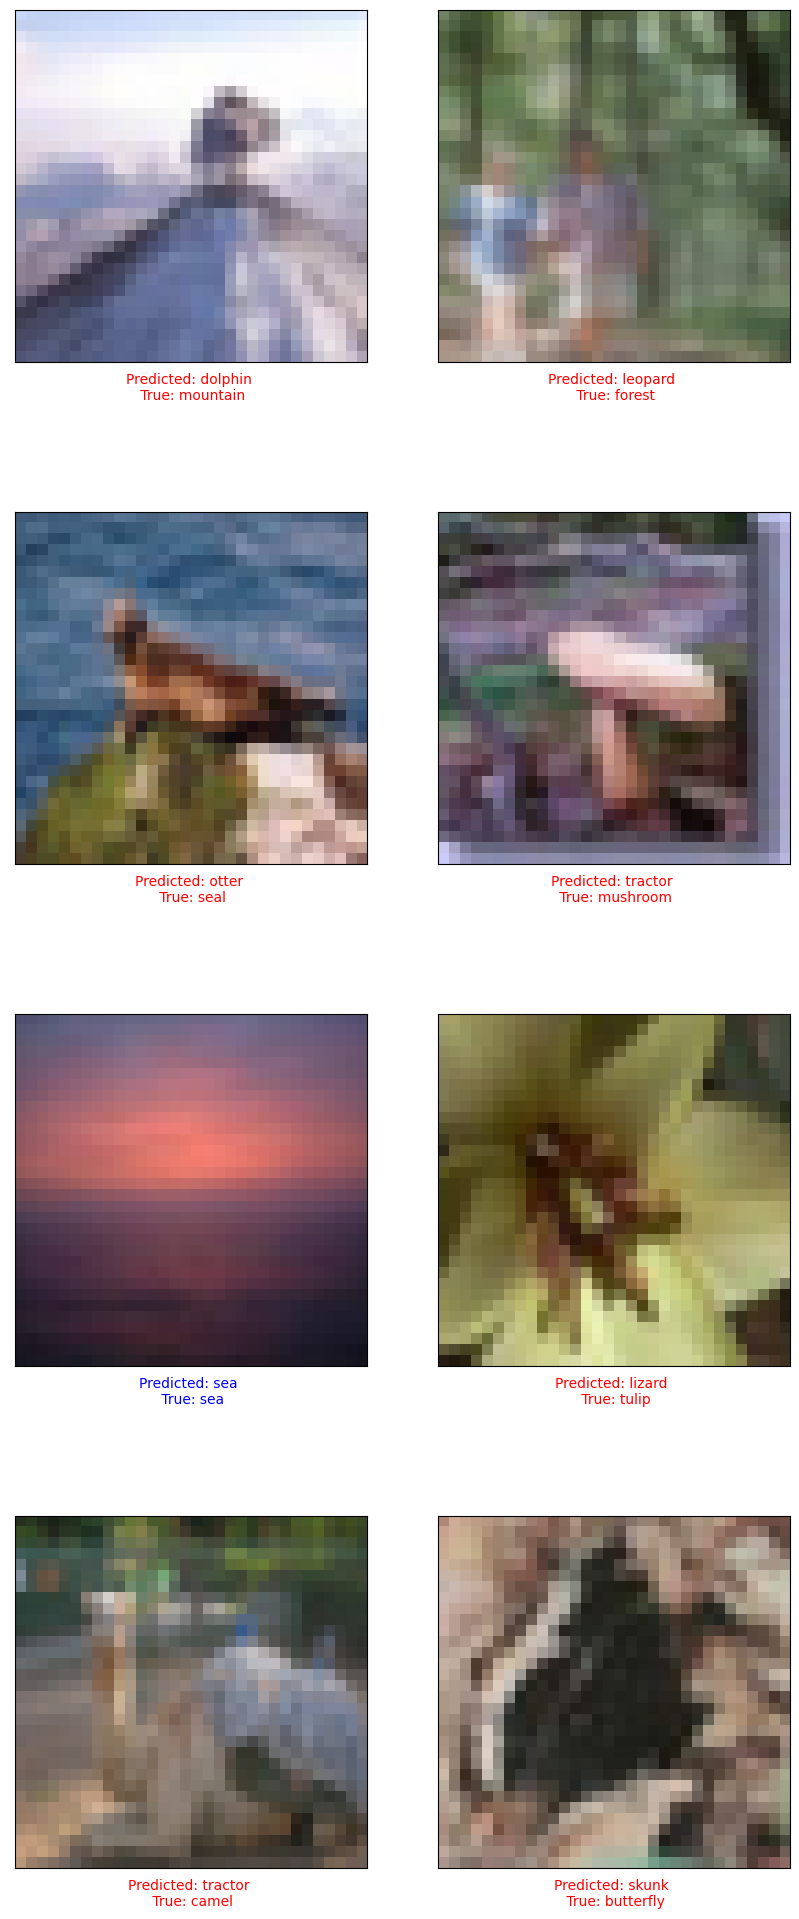

In [15]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_test[i]

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label[0]]}", color=color)
plt.show()

1/1 [==============================] - 0s 16ms/step


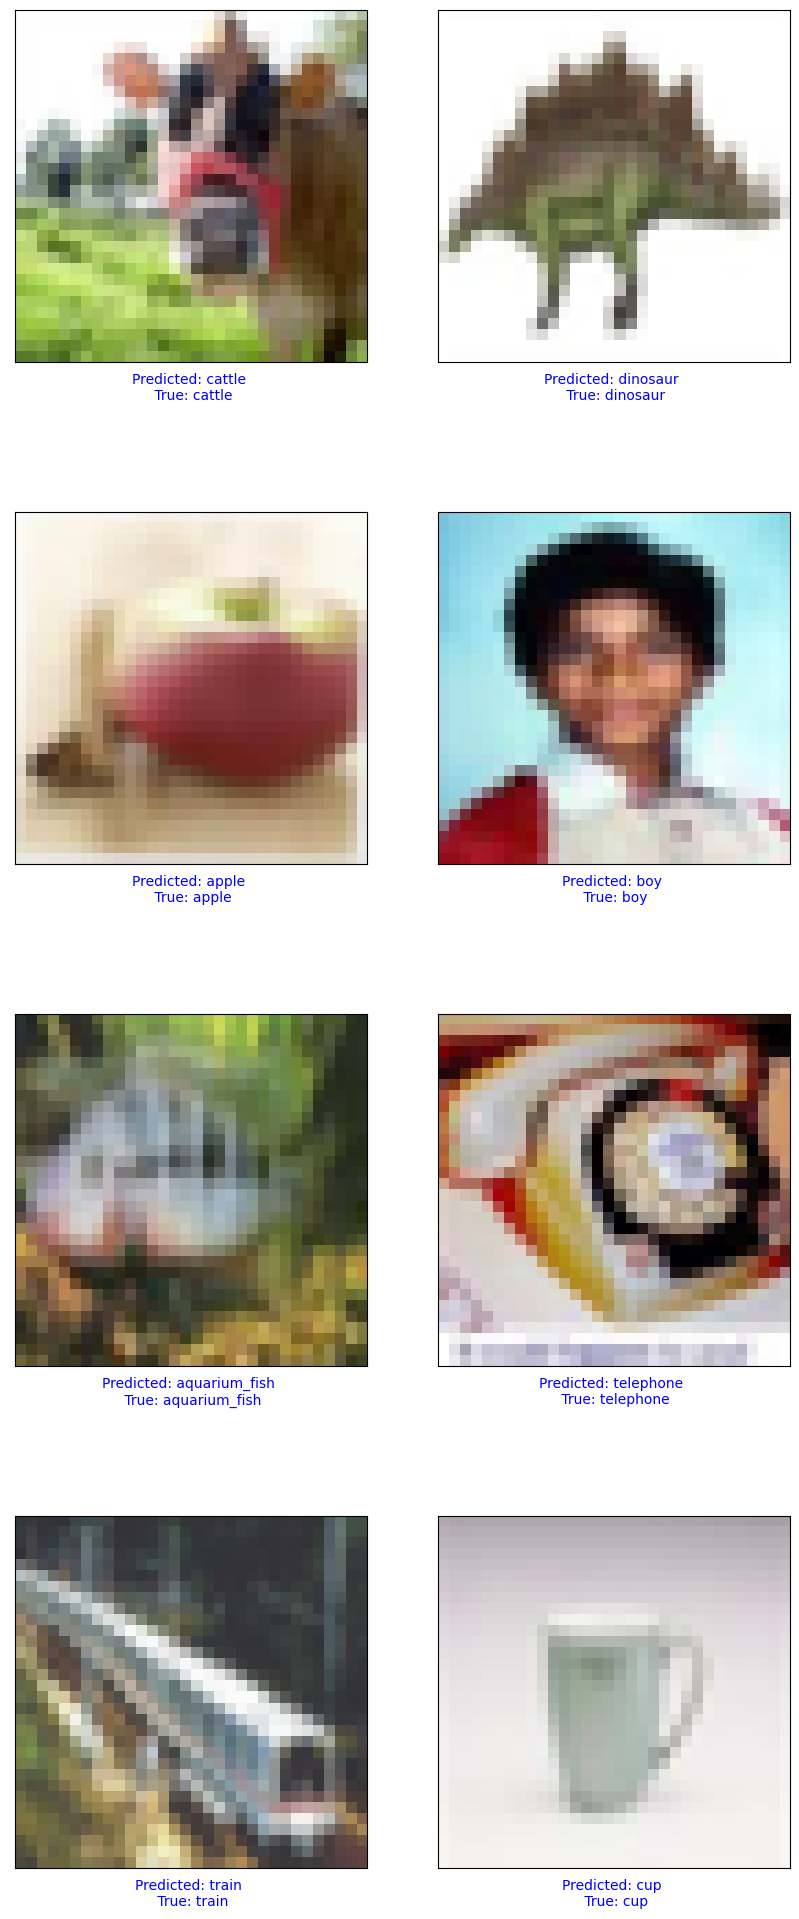

In [16]:
# Visualization X_train
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_train[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_train[i]

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label[0]]}", color=color)
plt.show()